In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense
import h5py

In [6]:
train_dataset = h5py.File("/mnt/c/Users/pssrg/Downloads/Image-Classification-Cat-vs-Non-Cat-master/Image-Classification-Cat-vs-Non-Cat-master/datasets/train_catvnoncat.h5", "r")

test_dataset = h5py.File("/mnt/c/Users/pssrg/Downloads/Image-Classification-Cat-vs-Non-Cat-master/Image-Classification-Cat-vs-Non-Cat-master/datasets/test_catvnoncat.h5", "r")


# Load training data
X_train = np.array(train_dataset["train_set_x"][:])  # shape: (m_train, 64, 64, 3)
Y_train = np.array(train_dataset["train_set_y"][:])  # shape: (m_train,)

# Load test data
X_test = np.array(test_dataset["test_set_x"][:])     # shape: (m_test, 64, 64, 3)
Y_test = np.array(test_dataset["test_set_y"][:])     # shape: (m_test,)
Y_train = Y_train.reshape(1, Y_train.shape[0])
Y_test = Y_test.reshape(1, Y_test.shape[0])
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)


In [7]:
# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

# Fix labels shape
Y_train_fixed = Y_train.reshape(-1)
Y_test_fixed = Y_test.reshape(-1)

In [8]:
def convolutional_model():
    model = Sequential()
    model.add(Input(shape=(64, 64, 3)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = convolutional_model()

model.fit(X_train, Y_train_fixed, validation_data=(X_test, Y_test_fixed), epochs=10, batch_size=32, verbose=2)
scores = model.evaluate(X_test, Y_test_fixed, verbose=0)
print("Accuracy: {:.2f}% \nError: {:.2f}%".format(scores[1]*100, 100 - scores[1]*100))

Epoch 1/10


I0000 00:00:1753464462.111081   21684 service.cc:152] XLA service 0x7faed0009820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753464462.111123   21684 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-25 17:27:42.145507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753464462.283787   21684 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753464463.911484   21684 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 - 4s - 534ms/step - accuracy: 0.6077 - loss: 1.0530 - val_accuracy: 0.3400 - val_loss: 0.7684
Epoch 2/10
7/7 - 0s - 15ms/step - accuracy: 0.6890 - loss: 0.5802 - val_accuracy: 0.3400 - val_loss: 0.8081
Epoch 3/10
7/7 - 0s - 11ms/step - accuracy: 0.6603 - loss: 0.5188 - val_accuracy: 0.4000 - val_loss: 0.7575
Epoch 4/10
7/7 - 0s - 11ms/step - accuracy: 0.7273 - loss: 0.4750 - val_accuracy: 0.7000 - val_loss: 0.6645
Epoch 5/10
7/7 - 0s - 10ms/step - accuracy: 0.7847 - loss: 0.4370 - val_accuracy: 0.5800 - val_loss: 0.6442
Epoch 6/10
7/7 - 0s - 11ms/step - accuracy: 0.8134 - loss: 0.4017 - val_accuracy: 0.7200 - val_loss: 0.5136
Epoch 7/10
7/7 - 0s - 10ms/step - accuracy: 0.8278 - loss: 0.3690 - val_accuracy: 0.6000 - val_loss: 0.6477
Epoch 8/10
7/7 - 0s - 11ms/step - accuracy: 0.8947 - loss: 0.3229 - val_accuracy: 0.6800 - val_loss: 0.5155
Epoch 9/10
7/7 - 0s - 12ms/step - accuracy: 0.8517 - loss: 0.3253 - val_accuracy: 0.6800 - val_loss: 0.5186
Epoch 10/10
7/7 - 0s - 11ms/step - acc

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(path, model):
    # Load and preprocess image
    img = Image.open(path).resize((64, 64))
    img_array = np.array(img) / 255.0  # Normalize
    
    if img_array.shape != (64, 64, 3):
        print("Image is not in expected format (64x64x3).")
        return
    
    # Add batch dimension: (1, 64, 64, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict probability
    prob = model.predict(img_array)[0][0]  # sigmoid output scalar
    
    prediction = int(prob > 0.5)
    
    plt.imshow(img)
    plt.axis('off')
    plt.title("Prediction: " + ("Cat" if prediction == 1 else "Not a Cat") + f" (Prob: {prob:.2f})")
    plt.show()
    
    return prediction

def test_accuracy(X_test, Y_test, model):
    # Predict on all test samples
    probs = model.predict(X_test).reshape(-1)
    
    preds = (probs > 0.5).astype(int)
    accuracy = np.mean(preds == Y_test.reshape(-1))
    correct = np.sum(preds == Y_test.reshape(-1))
    total = Y_test.shape[0] if len(Y_test.shape) == 1 else Y_test.shape[1]
    
    print(f"Accuracy on test set: {accuracy*100:.2f}%")
    print(f"Correct predictions: {correct} / {total}")
    
    return accuracy, correct

# Usage example:
# accuracy, correct = test_accuracy(X_test, Y_test_fixed, model)
# predict_image("path_to_image.jpg", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


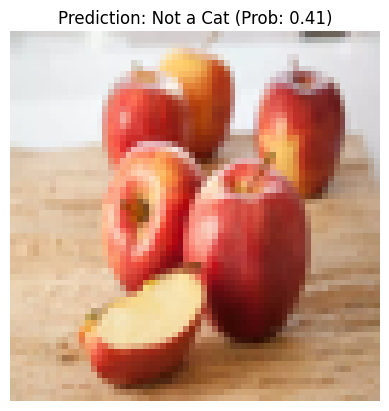

0

In [11]:
predict_image("/mnt/c/Users/pssrg/Downloads/Apples-184940975-770x533-1_jpg.webp", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


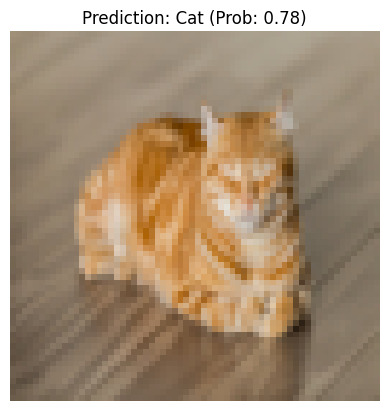

1

In [12]:
predict_image("/mnt/c/Users/pssrg/Downloads/Cat.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


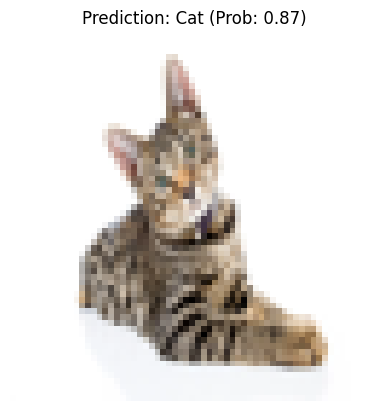

1

In [15]:
predict_image("/mnt/c/Users/pssrg/Downloads/gettyimages-1067956982.webp", model)

In [30]:
def convolutional_model_2():
    model = Sequential()
    model.add(Input(shape=(64, 64, 3)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_2 = convolutional_model()
model_2.fit(X_train, Y_train_fixed, validation_data=(X_test, Y_test_fixed), epochs=20, batch_size=32, verbose=2)
scores = model_2.evaluate(X_test, Y_test_fixed, verbose=0)
print("Accuracy: {:.2f}% \nError: {:.2f}%".format(scores[1]*100, 100 - scores[1]*100))

Epoch 1/20
7/7 - 4s - 533ms/step - accuracy: 0.4641 - loss: 0.9388 - val_accuracy: 0.3400 - val_loss: 0.9580
Epoch 2/20
7/7 - 0s - 38ms/step - accuracy: 0.6555 - loss: 0.5779 - val_accuracy: 0.3400 - val_loss: 0.7913
Epoch 3/20
7/7 - 0s - 40ms/step - accuracy: 0.6555 - loss: 0.4838 - val_accuracy: 0.3400 - val_loss: 1.0809
Epoch 4/20
7/7 - 0s - 36ms/step - accuracy: 0.7560 - loss: 0.4523 - val_accuracy: 0.6600 - val_loss: 0.6054
Epoch 5/20
7/7 - 0s - 38ms/step - accuracy: 0.8182 - loss: 0.4059 - val_accuracy: 0.7000 - val_loss: 0.5548
Epoch 6/20
7/7 - 0s - 39ms/step - accuracy: 0.8517 - loss: 0.3588 - val_accuracy: 0.9000 - val_loss: 0.4084
Epoch 7/20
7/7 - 0s - 35ms/step - accuracy: 0.8612 - loss: 0.3385 - val_accuracy: 0.7200 - val_loss: 0.5911
Epoch 8/20
7/7 - 0s - 36ms/step - accuracy: 0.9139 - loss: 0.2408 - val_accuracy: 0.8800 - val_loss: 0.4064
Epoch 9/20
7/7 - 0s - 37ms/step - accuracy: 0.9187 - loss: 0.2283 - val_accuracy: 0.5800 - val_loss: 0.7931
Epoch 10/20
7/7 - 0s - 37ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


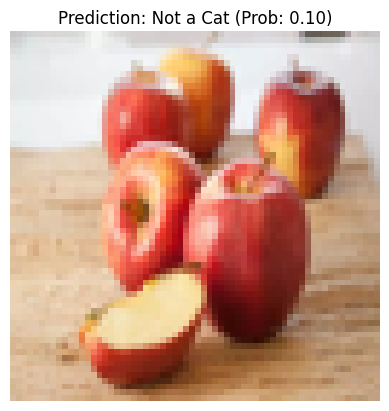

0

In [31]:
predict_image("/mnt/c/Users/pssrg/Downloads/Apples-184940975-770x533-1_jpg.webp", model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


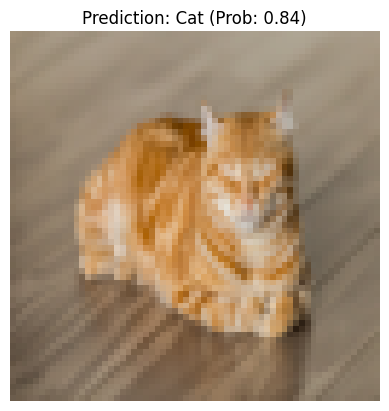

1

In [32]:
predict_image("/mnt/c/Users/pssrg/Downloads/Cat.jpg", model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


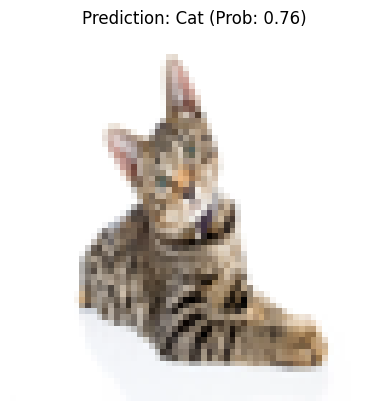

1

In [33]:
predict_image("/mnt/c/Users/pssrg/Downloads/gettyimages-1067956982.webp", model_2)